In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### check labelling

(1920, 2560, 3)
(68, 2)


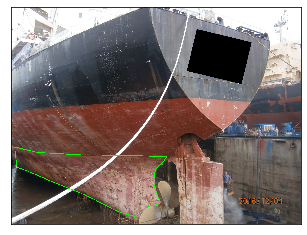

In [17]:
image_file = './Files/V12 71HR_PS VS S.4.png'
label_file = './Files/V12 71HR_PS VS S.4.csv'

image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)
# plt.imshow(image)
# plt.show()

label = pd.read_csv(label_file)
# label.head()

pts = label.values
print(pts.shape)
pts = pts.reshape((-1,1,2)).astype(int)
cv2.polylines(image, [pts], True, (0,255,0), thickness=5)
plt.xticks([])
plt.yticks([])
plt.imshow(image)
plt.show()

### test mask generating code

In [2]:
def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

In [13]:
row_id = 5
df = pd.read_csv("../data/severstal-steel-defect-detection/train.csv")
# https://www.kaggle.com/amanooo/defect-detection-starter-u-net
df['ClassId'] = df['ClassId'].astype(int)
df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
df['defects'] = df.count(axis=1)
    
fname, masks = make_mask(row_id, df)
print(fname)
print(masks.shape)

0025bde0c.jpg
(256, 1600, 4)


In [12]:
df.head(10)

ClassId,1,2,3,4,defects
ImageId,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,1
000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN,1
0025bde0c.jpg,NaN,NaN,8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...,315139 8 315395 15 315651 16 315906 17 316162 ...,2
002af848d.jpg,NaN,NaN,NaN,290800 6 291055 13 291311 15 291566 18 291822 ...,1
002fc4e19.jpg,146021 3 146275 10 146529 40 146783 46 147038 ...,145658 7 145901 20 146144 33 146386 47 146629 ...,NaN,NaN,2
0030401a5.jpg,NaN,NaN,NaN,186833 1 187089 3 187344 6 187600 7 187855 10 ...,1


In [17]:
np.sum(masks[:, :, 3])

17541.0

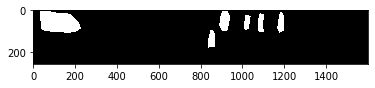

In [19]:
# values of 0.0s and 1.0s
plt.imshow(masks[:, :, 2], "gray")
plt.show()

### test custom mask generating code

In [2]:
from analysis import get_label_dict, resize_with_pad, make_mask

24097.0


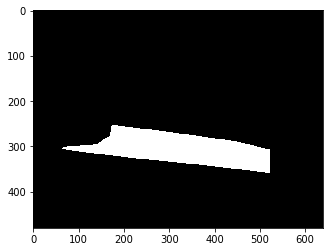

In [3]:
mask = np.zeros((3, 480, 640), dtype=np.float32)
f = '../data/labeled/labels/V1 1HR_PS BT S.1.csv'
df = pd.read_csv(f)
points = df.to_numpy()
cv2.fillConvexPoly(mask[0, :, :], points, 1.0)

print(np.sum(mask))

plt.imshow(mask[0, :, :], "gray")
plt.show()

In [4]:
image_dir = "../data/labeled/images"
label_dir = "../data/labeled/labels"
label_dict = get_label_dict(image_dir, label_dir)
class_index = {'STBD TS':0, 'STBD BT':1, 'STBD VS': 2, 'PS TS':3, 'PS BT':4, 'PS VS':5}
name = 'V4 23HR'

img = cv2.imread(os.path.join(image_dir, name+'.png'))
img, factor, pad = resize_with_pad(img)
mask = make_mask(name, label_dict, class_index, factor, pad)
print(img.shape, mask.shape)

(480, 640, 3) (480, 640, 6)


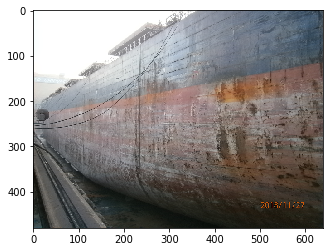

In [5]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

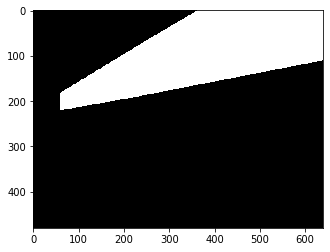

In [7]:
plt.imshow(mask[:, :, 3], "gray")
plt.show()